## Visualize site-year information

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import Purples_9

from ideotype.weafile_process import (wea_preprocess,
                                      wea_siteyears,
                                      wea_filter,
                                      wea_summarize)
from ideotype.nass_process import nass_summarize

Text(0.5, 0, 'stations')

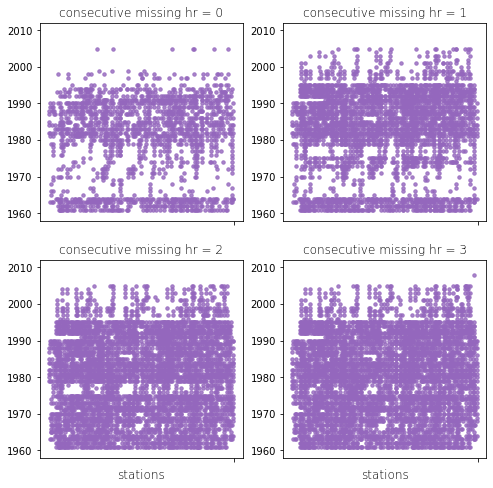

In [2]:
siteyear_ctr0 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr0.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr1 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr1.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv',
                           dtype={'site': object}, usecols=[1,2]) 
siteyear_ctr3 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr3.csv',
                           dtype={'site': object}, usecols=[1,2]) 

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(siteyear_ctr0.site, siteyear_ctr0.year, alpha=0.8, color='tab:purple', s=12)
ax1.set_ylim(1958, 2012)
ax1.set_xticks('')
ax1.set_title('consecutive missing hr = 0', fontweight='light')

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(siteyear_ctr1.site, siteyear_ctr1.year, alpha=0.8, color='tab:purple', s=12)
ax2.set_ylim(1958, 2012)
ax2.set_xticks('')
ax2.set_title('consecutive missing hr = 1', fontweight='light')

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(siteyear_ctr2.site, siteyear_ctr2.year, alpha=0.8, color='tab:purple', s=12)
ax3.set_ylim(1958, 2012)
ax3.set_xticks('')
ax3.set_title('consecutive missing hr = 2', fontweight='light')
ax3.set_xlabel('stations', fontsize=12, fontweight='light')

ax4 = fig.add_subplot(2,2,4)
ax4.scatter(siteyear_ctr3.site, siteyear_ctr3.year, alpha=0.8, color='tab:purple', s=12)
ax4.set_ylim(1958, 2012)
ax4.set_xticks('')
ax4.set_title('consecutive missing hr = 3', fontweight='light')
ax4.set_xlabel('stations', fontsize=12, fontweight='light')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/siteyears.png', format='png', dpi=800)

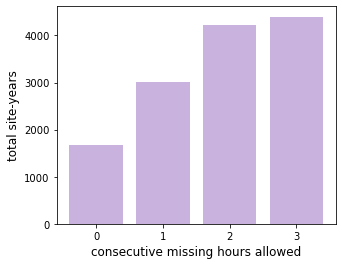

In [3]:
siteyears_ctr0 = siteyear_ctr0.shape[0]
siteyears_ctr1 = siteyear_ctr1.shape[0]
siteyears_ctr2 = siteyear_ctr2.shape[0]
siteyears_ctr3 = siteyear_ctr3.shape[0]

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ctrhr = [0,1,2,3]
siteyears = [siteyears_ctr0, siteyears_ctr1, siteyears_ctr2, siteyears_ctr3]
ax.bar(ctrhr, siteyears, alpha=0.5, color='tab:purple')
ax.set_xlabel('consecutive missing hours allowed', fontsize=12)
ax.set_ylabel('total site-years', fontsize=12)
ax.set_xticks([0,1,2,3])

In [2]:
# Run name
run_name = 'control_fixpd'

# Paths
basepath = '/home/disk/eos8/ach315/upscale/weadata/process'
outpath = '/home/disk/eos8/ach315/upscale/weadata'

# Preprocess combined weather data
df_temp, df_rh, df_precip, df_solrad = wea_preprocess(basepath)

# Select valid site-years
gseason_start = 2
gseason_end = 11
crthr = 2
siteyears = wea_siteyears(df_temp, df_rh, df_precip, df_solrad,
                          gseason_start, gseason_end, crthr)

In [3]:
# Filter site-years based on area, irrigation, & estimated pdate
area = 10000/2.47  # convert acre into ha
irri = 25
yearspersite = 15
df_siteyears = wea_filter(siteyears, area, irri, yearspersite)

print(f'siteyears: {df_siteyears.shape[0]}')
print(f'sites: {len(set(df_siteyears.site))}')

siteyears: 1160
sites: 60


In [5]:
# Add site info to siteyears
df_stations = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sites/stations_info_9110.csv', dtype={'USAF': str})
df_sites = df_stations[df_stations.USAF.isin(df_siteyears.site)][['USAF', 'NSRDB_LAT (dd)', 'NSRDB_LON(dd)']]
df_sites.columns = ['site', 'lat', 'lon']
df_sites['years'] = list(df_siteyears.groupby('site').count()['year'])

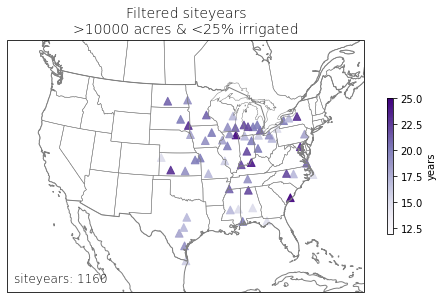

In [6]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123,-72,19,53])
mp = ax.scatter(df_sites.lon, df_sites.lat,
           transform=ccrs.PlateCarree(),
           c=df_sites.years,
           marker='^', s=60,
           cmap=Purples_9.mpl_colormap, alpha=0.9,
           vmin=12, vmax=25)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'Filtered siteyears\n'
             f'>{int(area*2.47)} acres & <{irri}% irrigated',
             fontweight='light', fontsize=14)
ax.text(-109, 22.5, f'siteyears: {df_siteyears.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=12)

fig.colorbar(mp, shrink=0.5, label='years')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/siteyears_filtered.png', format='png', dpi=800)

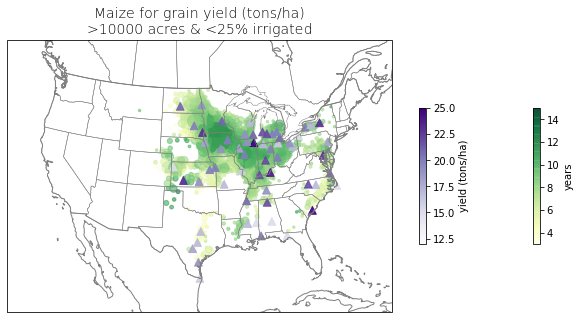

In [7]:
# Filters for year, planting area, & irrigation level
year_start = 2005
year_end = 2012

# Read in summarized NASS data
df_nass = nass_summarize(1961,2005)

# Filter NASS data
df_nass_summary = nass_summarize(year_start, year_end)
df_sub = df_nass_summary.query(f'(area > {area}) & (perct_irri < {irri})')

# Visualize yield
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123,-72,19,53])
mp1 = ax.scatter(df_sub.lon, df_sub.lat, 
           transform=ccrs.PlateCarree(),
           c=df_sub['yield'],
           s=df_sub['area']/700,
           cmap=YlGn_9.mpl_colormap, alpha=0.6,
           vmin=3, vmax=15)
mp2 = ax.scatter(df_sites.lon, df_sites.lat,
           transform=ccrs.PlateCarree(),
           c=df_sites.years,
           marker='^', s=60,
           cmap=Purples_9.mpl_colormap, alpha=0.9,
           vmin=12, vmax=25)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'Maize for grain yield (tons/ha)\n'
             f'>{int(area*2.47)} acres & <{irri}% irrigated',
             fontweight='light', fontsize=14)

fig.colorbar(mp1, shrink=0.5, label='years')
fig.colorbar(mp2, shrink=0.5, label='yield (tons/ha)')
fig.subplots_adjust(wspace=0.1, hspace=-0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/siteyears_filtered_nass.png', format='png', dpi=800)